In [3]:
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from data_loader import FlickrDataset, TestDataset, get_data_loader, get_test_data
from config import DATA_LOCATION, TEST_LOCATION, print_every
print('DATA_LOCATION:', DATA_LOCATION)

DATA_LOCATION: ./flickr8k/


### 2) **<b>Implementing the Helper function to plot the Tensor image**

In [21]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.savefig('show_img.png')
    plt.imshow(img)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
#Initiate the Dataset and Dataloader

#setting the constants
BATCH_SIZE = 256
# BATCH_SIZE = 6
NUM_WORKER = 1

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = DATA_LOCATION+"/images",
    caption_file = DATA_LOCATION+"/captions.txt",
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [7]:
resnet = models.resnet50(pretrained=True)
# print(resnet)

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [9]:
# Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)
        self.A = nn.Linear(attention_dim, 1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size, num_layers, attention_dim)
        w_ah = self.W(hidden_state) #(batch_size, attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha, attention_weights
        

In [11]:
# Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0]) - 1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [12]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


### 4) Setting Hypperparameter and Init the model

In [13]:
# Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [14]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    # print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step


In [15]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

import os

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_model = True
if os.path.exists("checkpoint.pth.tar"):
    step = load_checkpoint(torch.load("checkpoint.pth.tar"), model, optimizer)
    print(f'step {step} model loaded')

=> Loading checkpoint
step 3816 model loaded


## 5) Training Job from above configs

In [ ]:
import pdb
num_epochs = 1
step = 0

for epoch in range(1, num_epochs + 1):

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "step": step
    }
    save_checkpoint(checkpoint)

    for idx, data in enumerate(data_loader):
        # for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = data[0].to(device), data[1].to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        step += 1

        if (idx + 1) % print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img, _ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps, alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
    

## 6 Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [16]:
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps[:-1])
        show_image(features_tensors[0], title=caption)
    print("alphas.shape:",alphas[0].shape)
    return caps, alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    # print("type(attention_plot[0]):",type(attention_plot[0]))
    # print(attention_plot.shape)
    for l in range(len_result - 2):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        
    plt.tight_layout()
    plt.savefig('attention.png')
    plt.show()

def calculate_centroid(alpha):
    alpha = alpha.reshape(7, 7)
    m, n = alpha.shape
    centroid = np.zeros((1, 2))
    for i in range(m):
        for j in range(n):
            centroid += alpha[i, j] * np.array([i, j])
    return centroid

def maxpool_centroid(alpha):
    alpha = alpha.reshape(7, 7)
    m, n = alpha.shape
    max_cen = [(0, 0), -1]
    for i in range(m):
        for j in range(n):
            if alpha[i, j] > max_cen[1]:
                max_cen = [(i, j), alpha[i, j]] 
    return max_cen[0]
    # ax = fig.add_subplot(len_result//2,len_result//2, l+1)
    # ax.set_title(result[l])
    # img = ax.imshow(temp_image)
    # ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())

    # for i in range(m):
    #     for j in range(n):
    #         centroid += alphas[i, j] * np.array([i, j])
    # return centroid

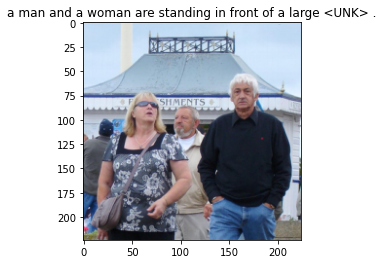

alphas.shape: (1, 49)


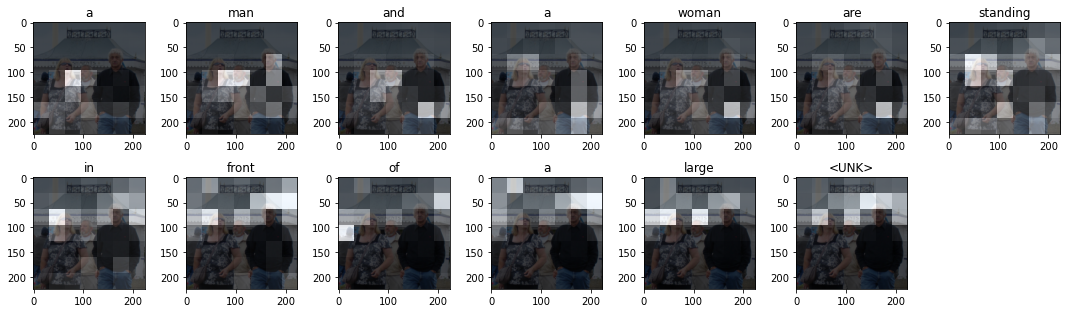

a: centroid1: [[4.3958768  2.45970669]] | centroid2: (3, 2)
man: centroid1: [[3.78792415 3.35645242]] | centroid2: (3, 2)
and: centroid1: [[4.13799366 3.40488037]] | centroid2: (5, 5)
a: centroid1: [[4.04381282 3.51411286]] | centroid2: (5, 5)
woman: centroid1: [[4.05790929 3.47702915]] | centroid2: (5, 5)
are: centroid1: [[3.81331018 3.44727158]] | centroid2: (5, 5)
standing: centroid1: [[3.48995964 3.16215792]] | centroid2: (2, 1)
in: centroid1: [[2.58925842 3.4611478 ]] | centroid2: (2, 1)
front: centroid1: [[1.76506467 3.26111778]] | centroid2: (1, 6)
of: centroid1: [[1.82992959 2.72264817]] | centroid2: (3, 0)
a: centroid1: [[1.27064892 3.05442641]] | centroid2: (1, 6)
large: centroid1: [[1.61421399 2.41795011]] | centroid2: (2, 1)
<UNK>: centroid1: [[1.3910229  3.33965265]] | centroid2: (1, 4)


In [17]:
from PIL import Image

img_name = '1198194316_543cc7b945.jpg'
# img_name = '130211457_be3f6b335d.jpg'
img_location = os.path.join(DATA_LOCATION+"/Images", img_name)
img = Image.open(img_location).convert("RGB")

#apply the transfromation to the image
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

img = transforms(img)
img1 = img.clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)
for i, alpha in enumerate(alphas[:-2]):
    centroid = calculate_centroid(alpha)
    centroid2 = maxpool_centroid(alpha)
    print(f"{caps[i]}: centroid1: {centroid} | centroid2: {centroid2}")

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


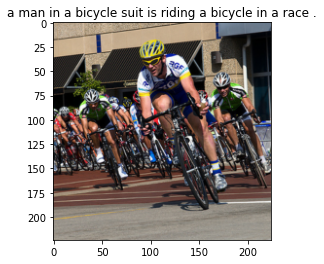

alphas.shape: (1, 49)


In [18]:
#show any 1
dataiter = iter(data_loader)
images, _ = next(dataiter)
print(type(images))


img = images[0].detach().clone()

print(img.shape)
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))


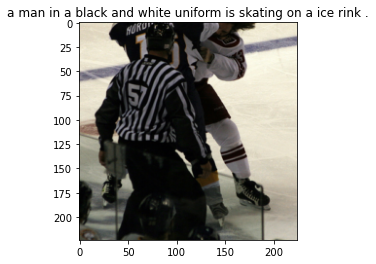

alphas.shape: (1, 49)


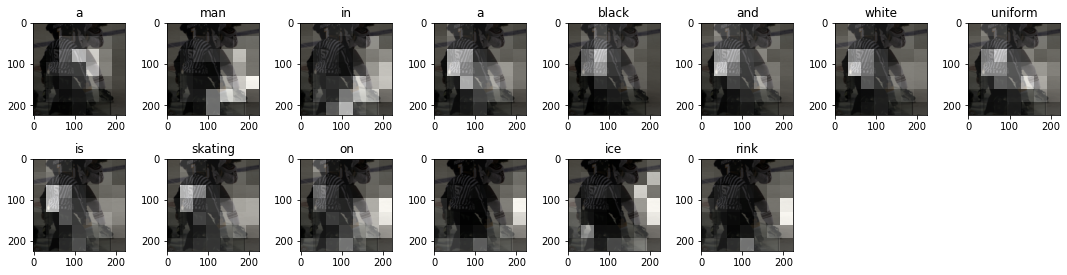

a: centroid1: [[2.65062235 3.33589595]] | centroid2: (2, 3)
man: centroid1: [[3.72663889 4.13372631]] | centroid2: (4, 6)
in: centroid1: [[3.79636867 3.76023199]] | centroid2: (6, 3)
a: centroid1: [[3.11546363 2.88968396]] | centroid2: (3, 1)
black: centroid1: [[2.35897348 2.58757463]] | centroid2: (2, 2)
and: centroid1: [[2.66619668 2.75915421]] | centroid2: (3, 1)
white: centroid1: [[2.87377862 2.86530052]] | centroid2: (3, 1)
uniform: centroid1: [[2.94275808 3.07761605]] | centroid2: (2, 2)
is: centroid1: [[3.17132595 2.98370791]] | centroid2: (3, 1)
skating: centroid1: [[3.27495259 3.19240243]] | centroid2: (2, 1)
on: centroid1: [[3.55801002 3.53683369]] | centroid2: (3, 6)
a: centroid1: [[4.01162124 3.9346    ]] | centroid2: (3, 6)
ice: centroid1: [[3.67760678 3.8166326 ]] | centroid2: (3, 6)
rink: centroid1: [[3.84379799 3.8698152 ]] | centroid2: (4, 6)


In [24]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)
for i, alpha in enumerate(alphas[:-2]):
    centroid = calculate_centroid(alpha)
    centroid2 = maxpool_centroid(alpha)
    print(f"{caps[i]}: centroid1: {centroid} | centroid2: {centroid2}")

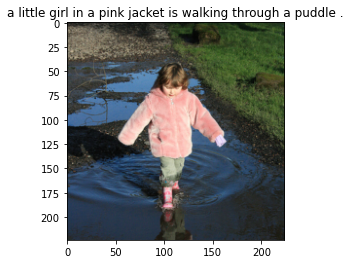

alphas.shape: (1, 49)


In [26]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

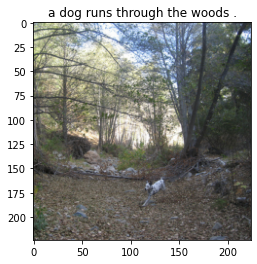

alphas.shape: (1, 49)


In [28]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))


In [30]:

print('load model!')
if load_model and os.path.exists("checkpoint.pth.tar"):
    step = load_checkpoint(torch.load("checkpoint.pth.tar"), model, optimizer)
    print(f'step {step} model loaded')
else:
    step = 0

    # if need_train:
    #     for epoch in range(1, num_epochs + 1):
    #         checkpoint = {
    #             "state_dict": model.state_dict(),
    #             "optimizer": optimizer.state_dict(),
    #             "step": step
    #         }
    #         save_checkpoint(checkpoint)

    #         for idx, data in enumerate(data_loader):
    #             image, captions = data[0].to(device), data[1].to(device)

    #             optimizer.zero_grad()
    #             outputs, attentions = model(image, captions)

    #             # Calculate the batch loss.
    #             targets = captions[:, 1:]
    #             loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
    #             loss.backward() # Backward pass.
    #             optimizer.step() # Update the parameters in the optimizer.

    #             step += 1

    #             if (idx + 1) % print_every == 0:
    #                 print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))

    

load model!
=> Loading checkpoint
step 3816 model loaded


test_data return type: <class 'PIL.Image.Image'>, <class 'list'>


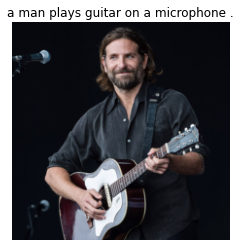

alphas.shape: (1, 49)
this is ['bradley_cooper']
['a', 'man', 'plays', 'guitar', 'on', 'a', 'microphone', '.', '<EOS>']
a man plays guitar on a microphone . => bradley_cooper plays guitar on a microphone 


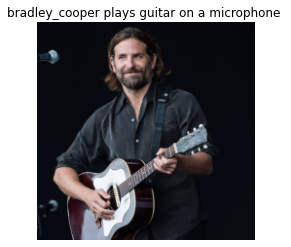

In [23]:
img, name_list = get_test_data()
# display image

# %% ---------------------------------------
from parse import replace_np, parse_np
transforms2 = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
img2 = img.copy()
img2 = transforms2(img2)

caps, alphas = get_caps_from(img2.unsqueeze(0))
print(f"this is {name_list}")
print(caps)
# %%
text = ' '.join(caps[:-1])
nps = parse_np(text)

words, total_num_of_people, tree = parse_np(text)
text2 = replace_np(text[: -1], nps, total_num_of_people, name_list, tree)
print(f'{text} => {text2}')
show_image(transforms2(img), title=text2)

